# Authors:
#### Parnian Razavipour | 99101665
#### Mobina Salimipanah | 99109788

---
---

The provided code consists of two classes (System and Packet) and three helper functions (get_priority, get_packet). Let's go through each part of the code to understand its functionality:

1. different ServicePolicies: This string variable defines three service policies: FIFO (First In, First Out), WRR (Weighted Round Robin), and NPPS (Non-Preemptive Priority Scheduling). These can be used to determine the order in which entities in the queue are served.
2. Class System: This class represents a queueing system. It has the following attributes:
max_capacity,
system_population,
Y(The service rate parameter).
current_time,
service_policy,
processor_start_times( A list that keeps track of start times of processors (servers))
processor_end_times(A list that keeps track of end times of processors (servers))
queue.
3.Class Packet: This class represents an entity in the queueing system.

Function get_priority: This function generates and returns a priority level for an entity based on a random value. The priority level is divided into three ranges: 0, 1, and 2.

Function get_packet: This function generates and returns a Packet object with random arrival time, service time, and priority level. It uses the System instance (s) to get the interarrival time and service time







In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math


class System():
    def __init__(self,X,Y,max_capacity,service_policy = "FIFO", processor_num = 1):
        self.max_capacity = max_capacity
        self.system_population = 0
        self.X = X
        self.Y = Y
        self.current_time = 0
        self.service_policy = service_policy
        self.processor_start_times = [0 for i in range(processor_num)]
        self.processor_end_times = [0 for i in range(processor_num)]
        self.queue = []

    def generate_interarrival(self):
     return np.random.exponential(scale=1/self.X)

    def generate_service_time(self):
     return np.random.exponential(scale=1/self.Y)



class Packet():
    def __init__(self,arrival_time,service_time,priority,queue_time = 0,departure_time = 0):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.priority = priority
        self.queue_time = queue_time
        self.departure_time = departure_time
        self.start_service = 0

In [ ]:
def get_priority():
    r = np.random.uniform(0.0, 1.0)
    if r < 0.5:
        return 0
    if r < 0.8:
        return 1
    else:
        return 2

def get_packet(s):
    s.current_time = round(s.current_time + s.generate_interarrival(),3)
    packet = Packet(arrival_time = s.current_time,
                    service_time = s.generate_service_time()
                    ,priority = get_priority())
    return packet

def create_packet_list(X, Y, max_capacity, service_policy):
    s = System(X=X, Y=Y, max_capacity=max_capacity, service_policy=service_policy, processor_num=PROCESSORS_NUM)
    packet_list = [Packet(arrival_time=0, service_time=s.generate_service_time(), priority=get_priority())]
    while s.current_time < T:
        packet_list.append(get_packet(s))
    s.current_time = 0
    return packet_list, s

---
# FIFO

**run_FIFO:** This function runs a simulation using the FIFO (First In, First Out) service policy. It creates the packet list and the System object using the create_packet_list function, and then calls the update_queue_and_processor function to update the queue and processor states. Finally, it calls the print_results function to display the simulation results.

In [ ]:
def update_queue_and_processor(packet_list, s):
    drop_list = []
    total_busy_time = [0 for _ in range(PROCESSORS_NUM)]
    total_time_spent_in_queue = 0
    high_priority_list = []

    for i in range(len(packet_list)):
        min_end = float('inf')
        min_idx = 0
        for j in range(PROCESSORS_NUM):
            if s.processor_end_times[j] < min_end:
                min_end = s.processor_end_times[j]
                min_idx = j
            if packet_list[i].arrival_time >= s.processor_end_times[j]:
                s.processor_start_times[j] = packet_list[i].arrival_time
                s.processor_end_times[j] = round(s.processor_start_times[j] + packet_list[i].service_time, 3)
                total_busy_time[j] = total_busy_time[j] + max(0, min(T - s.processor_start_times[min_idx], packet_list[i].service_time))
                packet_list[i].departure_time =  s.processor_end_times[j]
                if packet_list[i].priority == 2:
                    high_priority_list.append(packet_list[i].queue_time)
                break
        else:
            hold = []
            for k in range(len(s.queue)):
                if packet_list[i].arrival_time > s.queue[k].queue_time + s.queue[k].arrival_time:
                    hold.append(k)
                    s.system_population -= 1
            for k in range(len(hold)):
                s.queue.pop(0)
            if s.max_capacity == s.system_population:
                drop_list.append(packet_list[i])
            else:
                packet_list[i].queue_time = round(s.processor_end_times[min_idx] - packet_list[i].arrival_time, 3)
                total_time_spent_in_queue += packet_list[i].queue_time
                s.processor_start_times[min_idx] = s.processor_end_times[min_idx]
                s.processor_end_times[min_idx] = round(s.processor_start_times[min_idx] + packet_list[i].service_time, 3)
                packet_list[i].departure_time = s.processor_end_times[min_idx]
                total_busy_time[min_idx] = total_busy_time[min_idx] + max(0, min(T - s.processor_start_times[min_idx], packet_list[i].service_time))
                s.queue.append(packet_list[i])
                s.system_population += 1
                if packet_list[i].priority == 2:
                    high_priority_list.append(packet_list[i].queue_time)

    return total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list

def print_results(total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list, packet_list):
    print("Average queue length = ",  total_time_spent_in_queue / T)
    print("Average time spent in queue = ", total_time_spent_in_queue / len(packet_list))
    for i in range(len(total_busy_time)):
        print("Server Utilization of server", i," = ", total_busy_time[i]/T)
    print("Number of dropped packets = ", len(drop_list))

    if high_priority_list:
        high_priority_array = np.array(high_priority_list, dtype=float)
        cdf = np.cumsum(np.histogram(high_priority_array, bins=len(high_priority_array), range=(min(high_priority_array), max(high_priority_array)))[0]) / len(high_priority_array)
        plt.plot(np.arange(1, len(cdf)+1), cdf)
        plt.xlabel('Value')
        plt.ylabel('CDF')
        plt.title('CDF of queue time for high priority packets (FIFO)')
        plt.show()

def run_FIFO(X,Y):
    packet_list, s = create_packet_list(X,Y,sum(LENGTH_LIMIT),"FIFO" )
    total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list = update_queue_and_processor(packet_list, s)
    print_results(total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list, packet_list)

Average queue length =  2.9636000000000005
Average time spent in queue =  0.10816058394160585
Server Utilization of server 0  =  0.9632965357910349
Server Utilization of server 1  =  0.9329556653199376
Number of dropped packets =  28


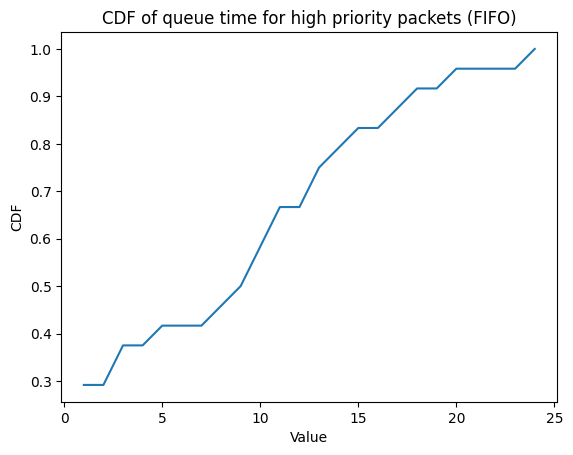

In [ ]:
PROCESSORS_NUM = 2
queue_numbers = 1


X = 25 #Poisson parameter
Y = 10 #Exp parameter
T = 5 #Simulation time
LENGTH_LIMIT = [5 for j in range(queue_numbers)]
run_FIFO(X, Y)

---
#NPPS

The NPPS (Non-Preemptive Priority Scheduling) policy focuses on determining the entry and exit times for packets in the queue. The packets are sorted based on arrival times in a list. When processing each packet, we check if there is available capacity in the system. If there is, we calculate the departure time and add it to the list. If the system is at capacity during packet arrival, the packet can either join the queue or be dropped. If there is a queue and an exit time is being checked, data is transferred from the queue to the server. If no queue exists at that moment, the check is ignored. This implementation effectively handles packet entry and exit times considering priorities and system capacity limitations.

In [ ]:

def update_queue_and_processor_npps(packet_list, s):
    drop_list = []
    total_busy_time = [0 for _ in range(PROCESSORS_NUM)]
    high_priority_list = []
    N = len(packet_list)
    t = 0
    processors_status = [False for j in range(PROCESSORS_NUM)]
    min_end_time = float('inf')
    count = 1
    t_list = [p.arrival_time for p in packet_list]
    total_time_spent_in_queue = 0

    while t < T:
        queue_packet = None
        p = None
        t = t_list.pop(0)
        if packet_list and t == packet_list[0].arrival_time:
            p = packet_list.pop(0)
        is_any_server_ready = False

        for j in range(PROCESSORS_NUM):
            if t >= s.processor_end_times[j]:
                processors_status[j] = False
                is_any_server_ready = True

        if is_any_server_ready and s.queue:
            queue_packet = s.queue.pop(0)
        if queue_packet != None:
            p = queue_packet
        if not p:
            continue

        count += 1
        for j in range(PROCESSORS_NUM):
            if not processors_status[j]:
                p.start_service = t
                if p.arrival_time > p.start_service:
                    break
                p.departure_time = round(t + p.service_time,3)
                p.queue_time = p.start_service - p.arrival_time
                total_time_spent_in_queue += p.queue_time
                total_busy_time[j] = total_busy_time[j] + max(0,min(T - p.start_service,p.service_time))
                if p.priority == 2:
                    high_priority_list.append(p.queue_time)
                s.processor_end_times[j] = p.departure_time
                processors_status[j] = True
                t_list.append(p.departure_time)
                t_list = sorted(t_list)
                break
        else:
            if len(s.queue) == s.max_capacity:
                drop_list.append(p)
            else:
                s.queue.append(p)
                s.queue = give_priority_in_queue(s,p)

    return total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list, N

def give_priority_in_queue(s,packet):
    for i in range(len(s.queue)-1,-1,-1):
        if packet.priority > s.queue[i].priority:
            s.queue[i+1], s.queue[i] = s.queue[i], s.queue[i+1]

    return s.queue

def run_NPPS(X, Y):
    packet_list, s = create_packet_list(X, Y, sum(LENGTH_LIMIT), "NPPS")
    total_busy_time, total_time_spent_in_queue, drop_list, high_priority_list, N = update_queue_and_processor_npps(packet_list, s)
    print("Average queue length = ", total_time_spent_in_queue / T)
    print("Average time spent in queue = ", total_time_spent_in_queue / N)
    for i in range(len(total_busy_time)):
        print("Server Utilization of server", i, " = ", total_busy_time[i] / T)
    print("Number of dropped packets = ", len(drop_list))
    high_priority_array = np.array(high_priority_list, dtype=float)
    cdf = np.cumsum(np.histogram(high_priority_array, bins=len(high_priority_array), range=(min(high_priority_array), max(high_priority_array)))[0]) / len(high_priority_array)
    plt.plot(np.arange(1, len(cdf) + 1), cdf, color='orange')  # Set the color to orange
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.title('CDF of queue time for high priority packets (NPPS)')
    plt.show()


Average queue length =  2.6948
Average time spent in queue =  0.10693650793650794
Server Utilization of server 0  =  0.9494386075426539
Server Utilization of server 1  =  0.9037316923058112
Number of dropped packets =  22


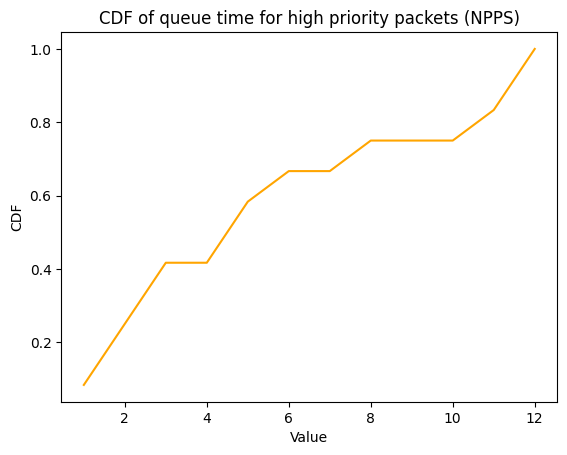

In [ ]:
PROCESSORS_NUM = 2
queue_numbers = 1

X = 25 #Poisson parameter
Y = 10 #Exp parameter
T = 5 #Simulation time
LENGTH_LIMIT = [5 for j in range(queue_numbers)]

run_NPPS(X,Y)

---
#WRR

In the implementation of the Weighted Round Robin (WRR) method, the queueing system consists of three different queues: one for low priority packets, one for medium priority packets, and one for high priority packets. The probabilities of creating packets with different priorities are as follows: 0.5 for low priority, 0.3 for medium priority, and 0.2 for high priority.

In the WRR method, when a server becomes idle and is ready to work, it removes packets from the queues in a specific order based on their priorities. Higher priority packets are removed first, followed by medium priority packets, and finally low priority packets. In this implementation, a fixed ratio of 5 high priority packets, 3 medium priority packets, and 2 low priority packets is selected for removal. If a certain type of packet is not found in the queue, the system proceeds to the next priority level and tries to remove packets from that queue.

This approach ensures that high priority packets are served with higher precedence, followed by medium priority packets, and finally low priority packets. The WRR method allows for differentiated service based on packet priority, ensuring that more critical packets receive timely processing and reducing the waiting time for high priority traffic.

In [ ]:
def run_WRR(X,Y,queue_weights=[5,3,2]):
    s = System(X=X,Y=Y,max_capacity=sum(LENGTH_LIMIT),processor_num=PROCESSORS_NUM)
    start_time = time.time()

    #WRR
    idle_time_of_server = [0,0,0]
    final_packet_list = []
    packet_list = []
    drop_list = []
    packet_list.append(Packet(arrival_time = 0, service_time=s.generate_service_time(), priority=get_priority()))
    total_busy_time = [0 for _ in range(PROCESSORS_NUM)]
    total_time_spent_in_queue = 0
    spent_time_in_queue_for_each_priority = [0,0,0]
    high_priority_list = []
    while s.current_time < T:
        packet_list.append(get_packet(s))
    s.current_time = 0

    three_separated_queues = [[] for i in range(3)]
    for i in range(len(packet_list)):
        packet_list[i].already_added = False

    counter_task = 0
    previous_time_a_server_finished = -1
    previous_final_packet_length = len(final_packet_list)
    continue_simulating = True
    while continue_simulating:
        min_end = float('inf')
        min_idx = 0
        for j in range(PROCESSORS_NUM):
            if s.processor_end_times[j] < min_end:
                min_end = s.processor_end_times[j]
                min_idx = j
        for i in range(len(packet_list)):
            if not packet_list[i].already_added:
                if previous_time_a_server_finished < packet_list[i].arrival_time <= min_end:
                    packet_list[i].already_added = True

                    if len(three_separated_queues[packet_list[i].priority]) < LENGTH_LIMIT[packet_list[i].priority]:
                        three_separated_queues[packet_list[i].priority].append(packet_list[i])
                    else:
                        drop_list.append(packet_list[i])
        previous_time_a_server_finished = min_end



        counter_task += 1
        which_queue_to_pick_weight_counter = counter_task
        while which_queue_to_pick_weight_counter > queue_weights[0] + queue_weights[1] + queue_weights[2]:
            which_queue_to_pick_weight_counter -= (queue_weights[0] + queue_weights[1] + queue_weights[2])
        if which_queue_to_pick_weight_counter <= queue_weights[0] + queue_weights[1] + queue_weights[2] and which_queue_to_pick_weight_counter > queue_weights[0] + queue_weights[1]:
            if len(three_separated_queues[2]) >= 1:
                final_packet_list.append(three_separated_queues[2][0])
                three_separated_queues[2].pop(0)
            else:
                counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + 1
                if len(three_separated_queues[0]) >= 1:
                    final_packet_list.append(three_separated_queues[0][0])
                    three_separated_queues[0].pop(0)
                else:
                    counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0] + queue_weights[1] + 1
                    if len(three_separated_queues[1]) >= 1:
                        final_packet_list.append(three_separated_queues[1][0])
                        three_separated_queues[1].pop(0)
                    else:
                        counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+queue_weights[2]

        elif which_queue_to_pick_weight_counter <= queue_weights[0] + queue_weights[1] and which_queue_to_pick_weight_counter > queue_weights[0]:
            if len(three_separated_queues[1]) >= 1:
                final_packet_list.append(three_separated_queues[1][0])
                three_separated_queues[1].pop(0)
            else:
                counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+1
                if len(three_separated_queues[2]) >= 1:
                    final_packet_list.append(three_separated_queues[2][0])
                    three_separated_queues[2].pop(0)
                else:
                    counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+queue_weights[2]+1
                    if len(three_separated_queues[0]) >= 1:
                        final_packet_list.append(three_separated_queues[0][0])
                        three_separated_queues[0].pop(0)
                    else:
                        counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+queue_weights[2]
                        ############
        elif which_queue_to_pick_weight_counter <= queue_weights[0]:
            if len(three_separated_queues[0]) >= 1:
                final_packet_list.append(three_separated_queues[0][0])
                three_separated_queues[0].pop(0)
            else:
                counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+1
                if len(three_separated_queues[1]) >= 1:
                    final_packet_list.append(three_separated_queues[1][0])
                    three_separated_queues[1].pop(0)
                else:
                    counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+1
                    if len(three_separated_queues[2]) >= 1:
                        final_packet_list.append(three_separated_queues[2][0])
                        three_separated_queues[2].pop(0)
                    else:
                        counter_task = (queue_weights[0] + queue_weights[1] + queue_weights[2]) * (counter_task // (queue_weights[0] + queue_weights[1] + queue_weights[2])) + queue_weights[0]+queue_weights[1]+queue_weights[2]

        if len(final_packet_list) > previous_final_packet_length:
            current_packet = final_packet_list[len(final_packet_list)-1] # server index = min_idx
            previous_final_packet_length = len(final_packet_list)
            current_packet.queue_time = round(max(0,s.processor_end_times[min_idx] - current_packet.arrival_time), 3)
            total_time_spent_in_queue += current_packet.queue_time
            spent_time_in_queue_for_each_priority[current_packet.priority] += current_packet.queue_time
            s.processor_start_times[min_idx] = s.processor_end_times[min_idx]
            s.processor_end_times[min_idx] = round(s.processor_start_times[min_idx] + current_packet.service_time, 3)
            current_packet.departure_time = s.processor_end_times[min_idx]
            total_busy_time[min_idx] = total_busy_time[min_idx] + max(0, min(T - s.processor_start_times[min_idx], current_packet.service_time))
            if current_packet.priority == 2:
                high_priority_list.append(current_packet.queue_time)

        else:

            first_index = -1
            for i in range(len(packet_list)):
                if min_end <= packet_list[i].arrival_time and first_index == -1 and (packet_list[i].already_added == False):
                    first_index = i
            if first_index == -1:
                continue_simulating =  False
                for sth in range(PROCESSORS_NUM):
                    idle_time_of_server[sth] += (T - s.processor_end_times[sth])
            else:
                idle_time_of_server[min_idx] += (packet_list[first_index].arrival_time - s.processor_end_times[min_idx])
                s.processor_end_times[min_idx] = packet_list[first_index].arrival_time

    print("Average queue length = ",  total_time_spent_in_queue / T)
    print("Average time spent in queue = ", total_time_spent_in_queue / len(packet_list))
    for i in range(3):
        if i == 0:
            string_in_output = 'low'
        elif i == 1:
            string_in_output = 'medium'
        else:
            string_in_output = 'high'
        print("(For Priority ", string_in_output, ") Average queue length = ", spent_time_in_queue_for_each_priority[i]/T)
        print("(For Priority ", string_in_output, ") Average time spent in queue = ", spent_time_in_queue_for_each_priority[i] / len(packet_list))
    for i in range(len(total_busy_time)):
        print("Server Utilization of server", i," = ", total_busy_time[i]/T)
    print("Number of dropped packets = ", len(drop_list))
    high_priority_array = np.array(high_priority_list, dtype=float)
    cdf = np.cumsum(np.histogram(high_priority_array, bins=len(high_priority_array), range=(min(high_priority_array), max(high_priority_array)))[0]) / len(high_priority_array)
    plt.plot(np.arange(1, len(cdf)+1), cdf, color='pink')
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.title('CDF of queue time for high priority packets (WRR)')
    plt.show()

Average queue length =  5.722200000000002
Average time spent in queue =  0.23645454545454553
(For Priority  low ) Average queue length =  2.1064
(For Priority  low ) Average time spent in queue =  0.08704132231404957
(For Priority  medium ) Average queue length =  1.6522000000000001
(For Priority  medium ) Average time spent in queue =  0.06827272727272728
(For Priority  high ) Average queue length =  1.9635999999999996
(For Priority  high ) Average time spent in queue =  0.08114049586776857
Server Utilization of server 0  =  0.9942740247430442
Server Utilization of server 1  =  0.9608005346323502
Number of dropped packets =  14


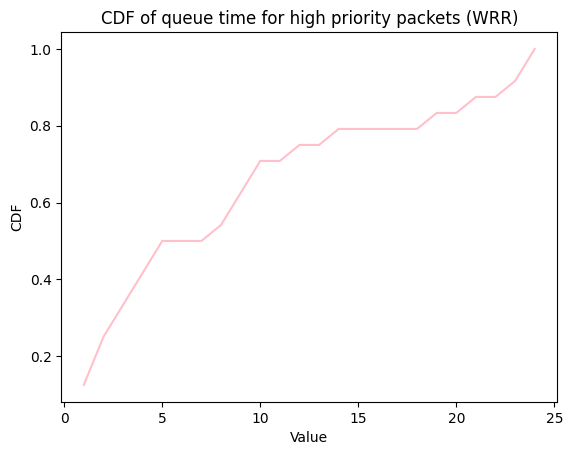

In [ ]:
PROCESSORS_NUM = 2
queue_numbers = 3

X = 25 #Poisson parameter
Y = 10 #Exp parameter
T = 5 #Simulation time
LENGTH_LIMIT = [5 for j in range(queue_numbers)]

run_WRR(X,Y)

**which of the routing policies in routers is more logical and Is it more appropriate to use it as a service policy?**
By repeating the test with different parameters and running the program, it can be seen that in almost all tests, the number of drops for fifo is less than the other two methods, and it can be concluded that this implementation is a better policy than the other two.

**increasing the efficiency of the system**
:To increase the efficiency of a queueing system, there are several approaches that can be taken:

1. **Adding more servers**: Increasing the number of servers can help reduce waiting times and improve overall system performance. With more servers, there is a higher capacity to handle incoming requests, resulting in shorter queue lengths and reduced waiting times for customers.

2. **Optimizing the queue policy**: The choice of queue policy, such as First In, First Out (FIFO), Priority-based, or Round Robin, can have a significant impact on system efficiency. Selecting the most appropriate queue policy based on the system requirements and characteristics can improve service levels and reduce waiting times for higher-priority requests.

3. **Optimizing packet arrival rate and service time distribution**: Analyzing and optimizing the arrival rate of packets and the service time distribution can help ensure a better balance between incoming requests and server capacity. By adjusting these parameters, the system can be fine-tuned to handle fluctuations in demand more effectively and reduce resource wastage.

4. **Implementing a more efficient event queue**: The event queue, which manages the order of events in the simulation, plays a crucial role in system efficiency. Optimizing the event queue data structure and algorithms can improve the performance of event handling and reduce the overall simulation time.

5. **Implementing parallel processing**: If the system allows for parallel processing, distributing the workload across multiple processors or threads can enhance system efficiency. This approach can enable concurrent processing of multiple requests, reducing the overall response time and improving system throughput.

The choice of optimization strategy will depend on the specific characteristics of the queueing system, such as arrival patterns, service requirements, and performance objectives. A comprehensive analysis of the system's behavior and careful consideration of these factors will help identify the most effective approaches to increase system efficiency.